# Predictive Analysis for CP Mortality Percentage of Population by Conditions Using Random Forest Regression

In [1]:
import os
from pathlib import Path
import sys

# set working directory to the module's home
cwd = os.getcwd()
os.chdir(Path(cwd).parents[1])

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from config import connect
from db_management.database_management import load_data
from modeling.random_forest_regression import RFRegressor

### Connect to MySQL Database `AQI` for the Table `combined`

In [3]:
conn = connect()
cursor = conn.cursor()

In [4]:
df = load_data(conn, "AQI", "combined")
df.head()

,Year,State,Parameter,AQI,Age_Group,Population,CP_deaths,Total_deaths,Pct_CP_Death
0,1980,Alabama,CO,39.61,< 1 year,63503.0,76.0,962.0,7.90
1,1980,Alabama,CO,39.61,1-4 years,237138.0,18.0,185.0,9.73
2,1980,Alabama,CO,39.61,5-9 years,314150.0,8.0,113.0,7.08
3,1980,Alabama,CO,39.61,10-14 years,328096.0,6.0,125.0,4.80
4,1980,Alabama,CO,39.61,15-19 years,377406.0,29.0,370.0,7.84


### Draw a random sample from the data of size 5000

In [5]:
sample_df = df.dropna().sample(n=5000)

### Build a Random Forest Regression (RFR) model fitted on the sample data

In [6]:
rfr = RFRegressor(target='Pct_CP_Death', features=['AQI', 'Parameter', 'Age_Group'], random_seed=123)

# removed State as a feature due to concern of overfitting

rfr

In [7]:
rfr.split_and_train(sample_df)

#### Hypertune model parameters and re-train it

In [8]:
parameters = {
    "n_estimators": [500, 1000, 1500, 2000],
}
rfr.hypertune(parameters)

{'n_estimators': 1000}


#### Predict the target using the train set and the test set. Plot the results for human-eye fit confirmation

In [9]:
y_predict_train, train_score = rfr.predict_score_train()
train_score

0.999787785267176

In [10]:
y_predict_test, test_score = rfr.predict_score_test()
test_score

0.9997941205559386

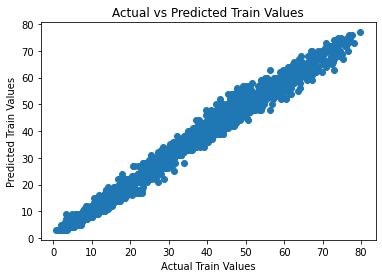

In [11]:
plt.scatter(rfr.y_train, y_predict_train)
plt.xlabel("Actual Train Values")
plt.ylabel("Predicted Train Values")
plt.title("Actual vs Predicted Train Values")
plt.show()

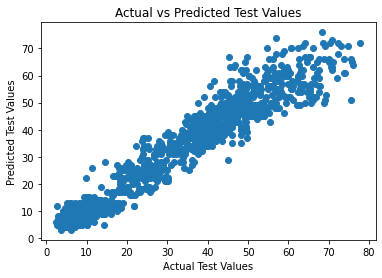

In [12]:
plt.scatter(rfr.y_test, y_predict_test)
plt.xlabel("Actual Test Values")
plt.ylabel("Predicted Test Values")
plt.title("Actual vs Predicted Test Values")
plt.show()

### Run the model on a different sample set of the data to see how it performs

In [13]:
sample_df2 = df.dropna().sample(n=1000)

In [14]:
pred_df = rfr.predict_data(sample_df2)

In [50]:
sample_df2

,Year,State,Parameter,AQI,Age_Group,Population,CP_deaths,Total_deaths,Pct_CP_Death,predicted_Pct_CP_Death,less_than_5_pct_diff
46913,1998,Illinois,PM10,28.87,25-34 years,1855595.0,312.0,1929.0,16.0,14.0,1
5765,1982,Missouri,SO2,65.32,10-14 years,377839.0,13.0,102.0,13.0,10.0,1
48024,1998,Ohio,CO,17.99,< 1 year,152794.0,60.0,1221.0,5.0,4.0,1
50929,1999,Pennsylvania,CO,23.40,65-74 years,982084.0,11291.0,24839.0,45.0,45.0,1
69616,2006,Pennsylvania,PM2.5,56.91,55-64 years,1427051.0,4473.0,12745.0,35.0,41.0,0
...,...,...,...,...,...,...,...,...,...,...,...
58877,2002,Oklahoma,NO2,28.46,15-19 years,265914.0,17.0,208.0,8.0,5.0,1
40500,1995,South Carolina,PM10,38.07,65-74 years,265157.0,3895.0,7577.0,51.0,52.0,1
87163,2013,Texas,CO,5.50,35-44 years,3578793.0,1323.0,5892.0,22.0,25.0,1
91354,2015,New York,SO2,2.07,75-84 years,871529.0,17343.0,36009.0,48.0,44.0,1


In [15]:
pred_df['less_than_5_pct_diff'] = 1
pred_df.loc[np.abs(pred_df['Pct_CP_Death'] - pred_df['predicted_Pct_CP_Death']) > 5, 'less_than_5_pct_diff'] = 0

pred_df.tail()

,Year,State,Parameter,AQI,Age_Group,Population,CP_deaths,Total_deaths,Pct_CP_Death,predicted_Pct_CP_Death,less_than_5_pct_diff
58877,2002,Oklahoma,NO2,28.46,15-19 years,265914.0,17.0,208.0,8.0,5.0,1
40500,1995,South Carolina,PM10,38.07,65-74 years,265157.0,3895.0,7577.0,51.0,52.0,1
87163,2013,Texas,CO,5.50,35-44 years,3578793.0,1323.0,5892.0,22.0,25.0,1
91354,2015,New York,SO2,2.07,75-84 years,871529.0,17343.0,36009.0,48.0,44.0,1
84239,2012,New Mexico,PM2.5,25.08,85+ years,34769.0,2168.0,4542.0,48.0,53.0,1


In [16]:
values = pred_df.less_than_5_pct_diff.value_counts()
values[1] / (values[1] + values[0])

0.752

### Plot Feature Importance

In [17]:
features = pd.DataFrame(
    {
        "field": rfr.rf_reg.feature_names_in_,
        "importance": rfr.rf_reg.feature_importances_
    }
)
features = features.set_index('field')
features

,importance
field,
AQI,0.052556
Parameter_CO,0.003079
Parameter_NO2,0.002094
Parameter_Ozone,0.001934
Parameter_PM10,0.001921
Parameter_PM2.5,0.002904
Parameter_SO2,0.001899
Age_Group_1-4 years,0.000488
Age_Group_10-14 years,0.000337


In [18]:
limited = features.sort_values("importance", ascending=False).head(10)

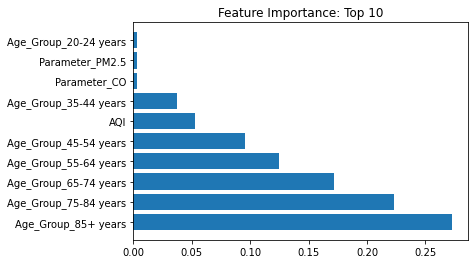

In [19]:
plt.barh(limited.index, limited.importance)
plt.title("Feature Importance: Top 10")
plt.show()

### Make data for Qlik

In [21]:
deploy_df = pred_df[["Parameter", "AQI", "Age_Group", "Pct_CP_Death", "predicted_Pct_CP_Death"]]
deploy_df.head()

,Parameter,AQI,Age_Group,Pct_CP_Death,predicted_Pct_CP_Death
46913,PM10,28.87,25-34 years,16.0,14.0
5765,SO2,65.32,10-14 years,13.0,10.0
48024,CO,17.99,< 1 year,5.0,4.0
50929,CO,23.40,65-74 years,45.0,45.0
69616,PM2.5,56.91,55-64 years,35.0,41.0


In [24]:
np.ceil(df.AQI.max())

158.0

In [34]:
aqi_range = range(0, int(np.ceil(df.AQI.max())+1))
aqi_list = list(aqi_range)

In [37]:
param_list = df.Parameter.unique().tolist()
param_list

['CO', 'NO2', 'Ozone', 'SO2', 'PM10', 'PM2.5']

In [33]:
age_list = df.Age_Group.unique().tolist()[:-1]
age_list

['< 1 year',
 '1-4 years',
 '5-9 years',
 '10-14 years',
 '15-19 years',
 '20-24 years',
 '25-34 years',
 '35-44 years',
 '45-54 years',
 '55-64 years',
 '65-74 years',
 '75-84 years',
 '85+ years']

In [35]:
import itertools

In [41]:
a = [aqi_range, param_list, age_list]
result = list(itertools.product(*a))

In [48]:
new_df = pd.DataFrame(result, columns=['AQI', 'Parameter', 'Age_Group'])
new_df

,AQI,Parameter,Age_Group
0,0,CO,< 1 year
1,0,CO,1-4 years
2,0,CO,5-9 years
3,0,CO,10-14 years
4,0,CO,15-19 years
...,...,...,...
12397,158,PM2.5,45-54 years
12398,158,PM2.5,55-64 years
12399,158,PM2.5,65-74 years
12400,158,PM2.5,75-84 years


In [52]:
dep_df = rfr.predict_data(new_df, round_target=False)
dep_df["predicted_Pct_CP_Death"] = dep_df.predicted_Pct_CP_Death.astype(int)
dep_df

,AQI,Parameter,Age_Group,predicted_Pct_CP_Death
0,0,CO,< 1 year,4
1,0,CO,1-4 years,13
2,0,CO,5-9 years,17
3,0,CO,10-14 years,13
4,0,CO,15-19 years,7
...,...,...,...,...
12397,158,PM2.5,45-54 years,37
12398,158,PM2.5,55-64 years,39
12399,158,PM2.5,65-74 years,49
12400,158,PM2.5,75-84 years,59


In [54]:
dep_df.to_csv("data/rfr_results.csv")

In [63]:
test_train = pd.DataFrame({"actual": rfr.y_train, "predicted": y_predict_train, "test_or_train":"train"}).append(pd.DataFrame({"actual": rfr.y_test, "predicted": y_predict_test, "test_or_train":"test"})).reset_index(drop=True)

In [64]:
test_train.to_csv("data/rfr_test_train.csv")